In [22]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import argparse
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

sys.path.append("../../")
from src.model.video_diffusion_pytorch_conv3d import Unet3D_with_Conv3D
from src.model.fno import FNO3D
from src.train.nuclear_thermal_coupling import load_nt_dataset_emb, cond_emb, normalize, renormalize
from src.utils.utils import L2_norm, get_parameter_net, plot_compare_2d, relative_error

In [23]:
device = "cuda"
iter = "iter1"
model_type = "Unet"

# neutron

In [24]:
train_which = "neutron"
dim = 8
emb = cond_emb(train_which, device=device)

In [25]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":
    model_neu = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=0,
        channels=len(emb),
        out_dim=1,
        cond_emb=emb,
        time_cond=False,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)

    model_neu.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateUnetneutron/" + iter + "_5000/model.pt")["model"]
    )
elif model_type == "FNO":
    model_neu = FNO3D(
        in_channels=len(emb),
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=8,
        fno_modes=[6, 16, 8],
        cond_emb=emb,
    ).to(device)
    model_neu.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateFNOneutron/" + iter + "_5000/model.pt")["model"]
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_36188\141926468.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/surroga

In [26]:
b = -1
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = model_neu(cond)
    pred = renormalize(pred, "neutron")
    data = renormalize(data, "neutron")
    rmse = relative_error(data, pred)
    mse = F.mse_loss(pred, data)
    # print(get_relative_error(model_neu, cond, data, batchsize=32))
rmse, mse

(0.002344012027606368, tensor(2.0590e-05, device='cuda:0'))

In [28]:
from thop import profile

flops, params = profile(model_neu, (cond,))
print("flops: %.2f M, params: %.2f M" % (flops / 1e6, params / 1e6))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv3d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose3d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
flops: 2404.84 M, params: 0.37 M


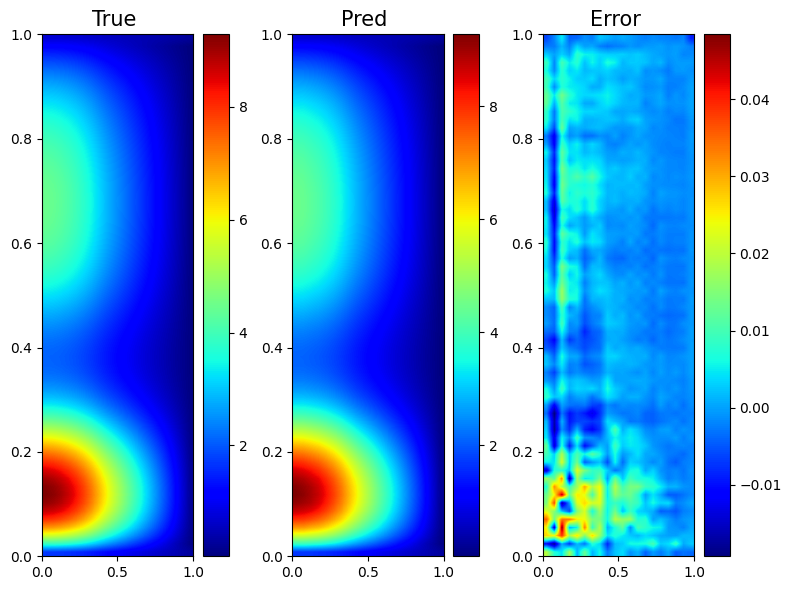

In [6]:
plot_compare_2d(data[-1, -1, -1], pred[-1, -1, -1])

# fuel

In [30]:
train_which = "solid"
dim = 8
emb = cond_emb(train_which, device=device)

In [31]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":
    model_fuel = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=0,
        channels=len(emb),
        out_dim=1,
        cond_emb=emb,
        time_cond=False,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)
    model_fuel.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateUnetsolid/" + iter + "_5000/model.pt")["model"]
    )
elif model_type == "FNO":
    model_fuel = FNO3D(
        in_channels=len(emb),
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=8,
        fno_modes=[6, 16, 4],
        cond_emb=emb,
    ).to(device)
    model_fuel.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateFNOsolid/" + iter + "_5000/model.pt")["model"]
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_36188\314746082.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/surroga

In [32]:
b = -1
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = model_fuel(cond)
    pred = renormalize(pred, "solid")
    data = renormalize(data, "solid")
    rmse = relative_error(data, pred)
    mse = F.mse_loss(pred, data)
    # print(get_relative_error(model_neu, cond, data, batchsize=32))
rmse, mse

(0.001060302834957838, tensor(0.3530, device='cuda:0'))

In [34]:
from thop import profile

flops, params = profile(model_fuel, (cond,))
print("flops: %.2f M, params: %.2f M" % (flops / 1e6, params / 1e6))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv3d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose3d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
flops: 480.97 M, params: 0.37 M


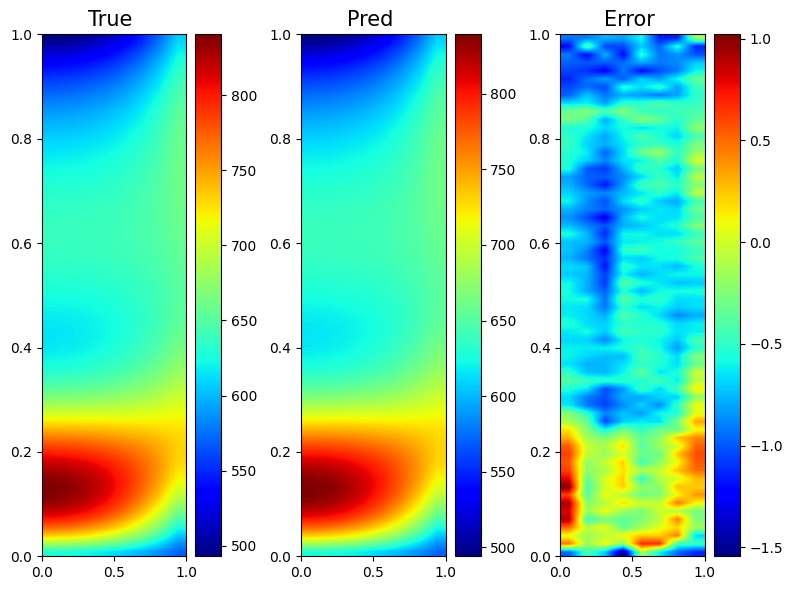

In [10]:
plot_compare_2d(data[-1, -1, -1], pred[-1, -1, -1])

# fluid

In [35]:
train_which = "fluid"
dim = 16
emb = cond_emb(train_which, device=device)

In [36]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":
    model_fluid = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=0,
        channels=len(emb),
        out_dim=4,
        cond_emb=emb,
        time_cond=False,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)

    model_fluid.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateUnetfluid/" + iter + "_5000/model.pt")["model"]
    )
elif model_type == "FNO":
    model_fluid = FNO3D(
        in_channels=len(emb),
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=16,
        fno_modes=[6, 16, 6],
        cond_emb=emb,
    ).to(device)
    model_fluid.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/surrogateFNOfluid/" + iter + "_5000/model.pt")["model"]
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_36188\3377838504.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/surrog

In [37]:
b = -1
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = model_fluid(cond)
    pred = renormalize(pred, field="fluid")
    data = renormalize(data, field="fluid")

In [39]:
from thop import profile

flops, params = profile(model_fluid, (cond,))
print("flops: %.2f M, params: %.2f M" % (flops / 1e6, params / 1e6))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv3d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose3d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
flops: 2637.50 M, params: 1.38 M


In [14]:
loss_fluid = 0
for i in range(4):
    cu_loss = relative_error(data[:, i], pred[:, i])
    print(cu_loss)
    loss_fluid += cu_loss
relative_error(data, pred), loss_fluid / 4

0.0007299660355783999
0.00286125298589468
0.011975118890404701
0.0005265663494355977


(0.0009266388369724154, 0.004023226065328345)

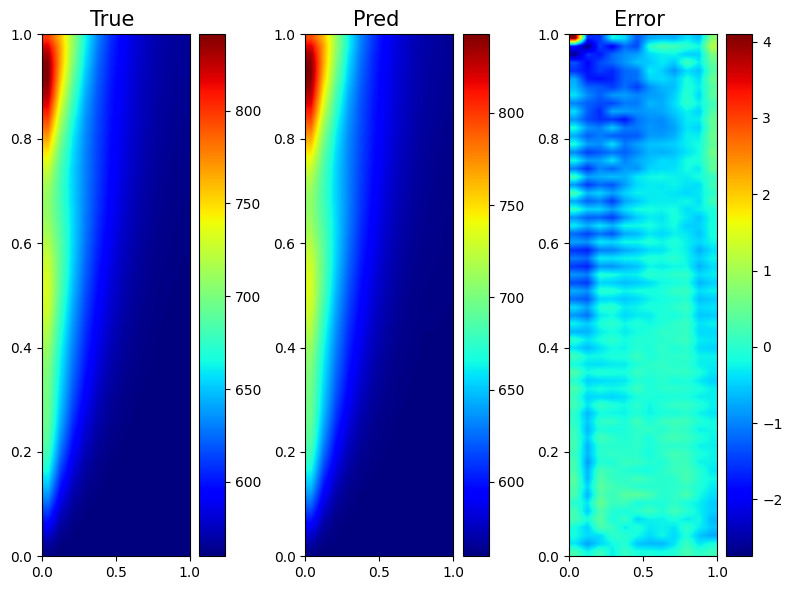

In [15]:
channel = 0
plot_compare_2d(data[-2, channel, -1], pred[-2, channel, -1])

# combine

In [16]:
b = 1
fuel = torch.tensor(np.load("../../data/NTcouple/val/fuel.npy")).float().to(device)[:b]


fluid = torch.tensor(np.load("../../data/NTcouple/val/fluid.npy")).float().to(device)[:b]


neu = torch.tensor(np.load("../../data/NTcouple/val/neu.npy")).float().to(device)[:b]


bc = torch.tensor(np.load("../../data/NTcouple/val/bc.npy")).float().to(device)[:b]

b = bc.shape[0]

In [17]:
fuel.shape, fluid.shape, neu.shape

(torch.Size([1, 1, 16, 64, 8]),
 torch.Size([1, 4, 16, 64, 12]),
 torch.Size([1, 1, 16, 64, 20]))

In [18]:
fluid_p = renormalize(torch.ones_like(fluid) * 0.5, "fluid")
fuel_p = renormalize(torch.ones_like(fuel) * 0.5, "solid")
neu_p = renormalize(torch.ones_like(neu) * 0.5, "neutron")

In [19]:
def k(t):
    return 17.5 * (1 - 0.223) / (1 + 0.161) + 1.54e-2 * (1 + 0.0061) / (1 + 0.161) * t + 9.38e-6 * t * t


def update_f_neu(model, neu, fuel, fluid, arg):
    fuel_n = normalize(fuel, "solid")
    fluid_n = normalize(fluid[:, :1], "fluid")
    arg_n = normalize(arg, "neutron")
    T_n = torch.concat((fuel_n, fluid_n), dim=-1)
    # print(fuel_n.shape, fluid_n.shape, arg_n.shape, T_n.shape)
    neu_p = model([arg_n, T_n])
    return renormalize(neu_p, "neutron")


def update_f_fuel(model, neu, fuel, fluid, arg):
    neu_n = normalize(neu[..., :8], "solid")
    fluid_n = normalize(fluid, "fluid")[:, 0:1, :, :, 0:1]
    fuel_p = model([neu_n, fluid_n])
    return renormalize(fuel_p, "solid")


def update_f_fluid(model, neu, fuel, fluid, arg):
    flux = (fuel[..., -2:-1] - fuel[..., -1:None]) * k(fuel[..., -1:None])
    flux_n = normalize(flux, "flux")
    fluid_pp = model([flux_n])
    return renormalize(fluid_pp, "fluid")

In [ ]:
import time

coeff = 0.5


max_iter = 100
start = time.time()


with torch.no_grad():

    for i in range(max_iter):
        neu_p_old = neu_p
        fuel_p_old = fuel_p
        fluid_p_old = fluid_p
        neu_p = update_f_neu(
            model_neu, neu_p.clone(), fuel_p.clone(), fluid_p.clone(), bc.clone()
        ) * coeff + neu_p_old * (1 - coeff)
        fuel_p = update_f_fuel(
            model_fuel, neu_p.clone(), fuel_p.clone(), fluid_p.clone(), bc.clone()
        ) * coeff + fuel_p_old * (1 - coeff)
        fluid_p = update_f_fluid(
            model_fluid, neu_p.clone(), fuel_p.clone(), fluid_p.clone(), bc.clone()
        ) * coeff + fluid_p_old * (1 - coeff)

        loss1 = np.sum(L2_norm(neu_p - neu_p_old) / L2_norm(neu_p)) / neu_p.shape[0]

        loss2 = np.sum(L2_norm(fuel_p - fuel_p_old) / L2_norm(fuel_p)) / fuel_p.shape[0]

        loss3 = np.sum(L2_norm(fluid_p - fluid_p_old) / L2_norm(fluid_p)) / fluid_p.shape[0]

        loss = (loss1 + loss2 + loss3) / 3

        print("loss: ", loss, loss1, loss2, loss3)

        if loss < 1e-4:

            print("converse in iteration: ", i)

            break

        if i == max_iter - 1:

            print("up to max iteration")
end = time.time()
print("time: ", (end - start) / (i + 1) / 2)

loss:  0.37601585189501446 0.6064559817314148 0.25068822503089905 0.2709033489227295
loss:  0.32741157213846844 0.5885565280914307 0.2388954609632492 0.1547827273607254
loss:  0.21909273664156595 0.3975324034690857 0.18002372980117798 0.0797220766544342
loss:  0.1322820819914341 0.24273860454559326 0.10516008734703064 0.04894755408167839
loss:  0.07211732429762681 0.13821513950824738 0.04986770078539848 0.02826913259923458
loss:  0.037065114515523113 0.074884794652462 0.022247828543186188 0.014062720350921154
loss:  0.019455875890950363 0.039245788007974625 0.010055202059447765 0.009066637605428696
loss:  0.010982939197371403 0.02019008807837963 0.0067978594452142715 0.0059608700685203075
loss:  0.00656463298946619 0.01033797487616539 0.005820117425173521 0.00353580666705966
loss:  0.003967488960673411 0.005309046246111393 0.0035815725568681955 0.0030118480790406466
loss:  0.002310193687056502 0.0027220381889492273 0.0021229195408523083 0.0020856233313679695
loss:  0.001450195248859624

In [22]:
loss_fluid = 0
for i in range(4):
    cu_loss = relative_error(fluid[:, i], fluid_p[:, i])
    print(cu_loss)
    loss_fluid += cu_loss
loss_fluid = loss_fluid / 4
relative_error(neu, neu_p), relative_error(fuel, fuel_p), relative_error(fluid, fluid_p), loss_fluid

0.08550669252872467
0.5416604280471802
1.2540366649627686
0.06266570836305618


(0.22066844999790192,
 0.3181896209716797,
 0.10188286751508713,
 0.4859673734754324)

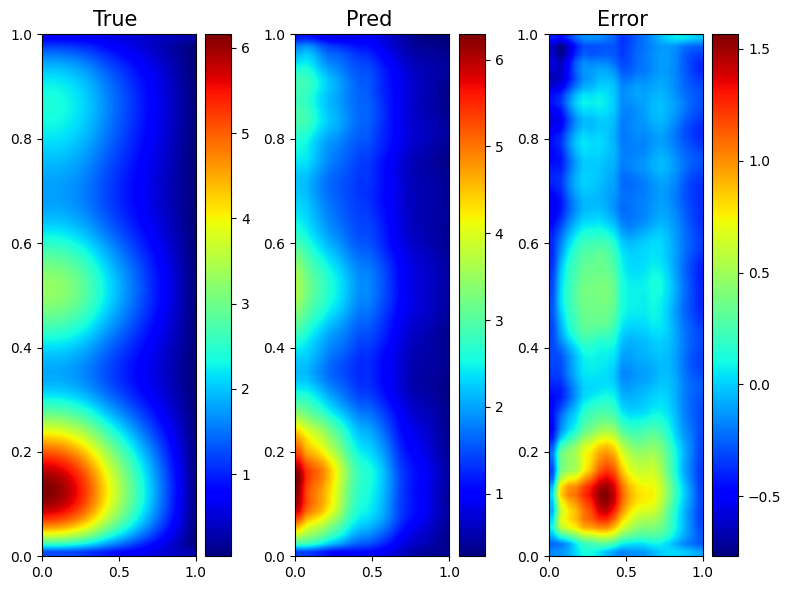

In [ ]:
pred, data = neu_p, neu
channel = 0
plot_compare_2d(
    data[-1, channel, -1],
    pred[-1, channel, -1],
    savep="../../results/nuclear_thermal_coupling/neutron_surrogate" + model_type + ".png",
)

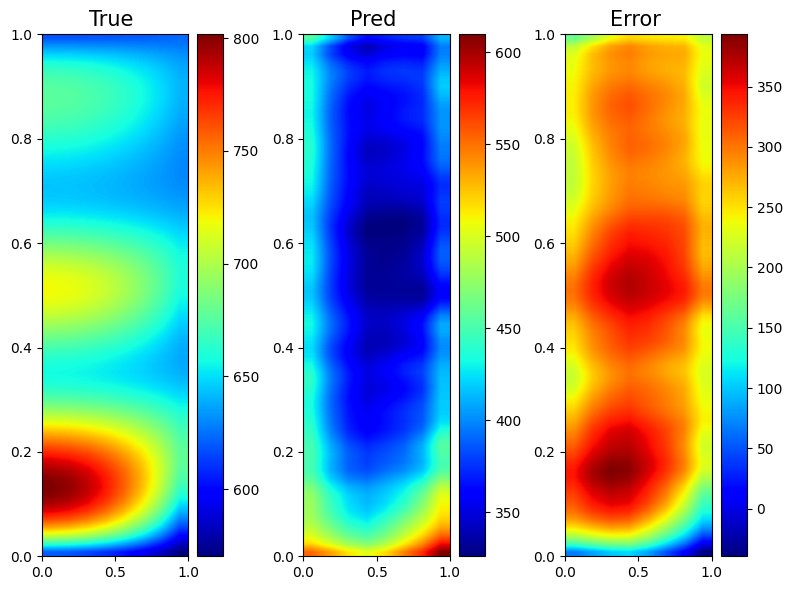

In [ ]:
pred, data = fuel_p, fuel
channel = 0
plot_compare_2d(
    data[-1, channel, -1],
    pred[-1, channel, -1],
    savep="../../results/nuclear_thermal_coupling/solid_surrogate" + model_type + ".png",
)

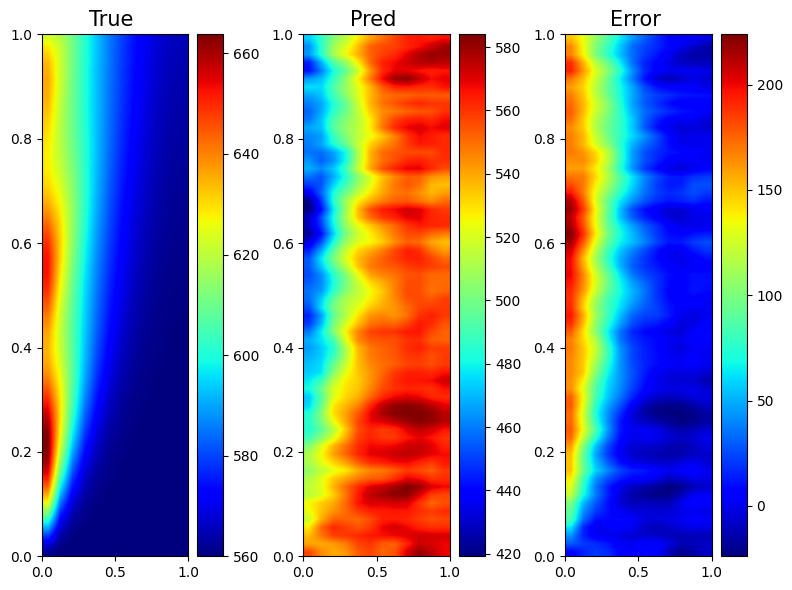

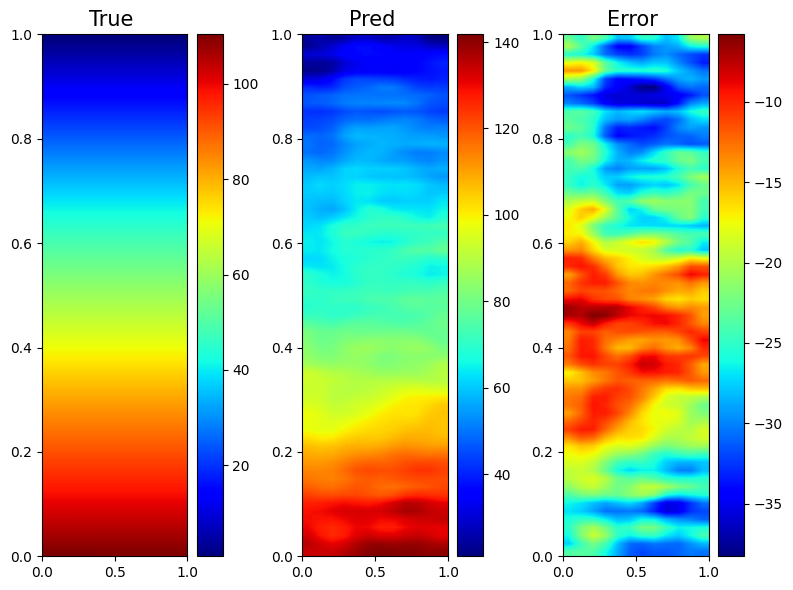

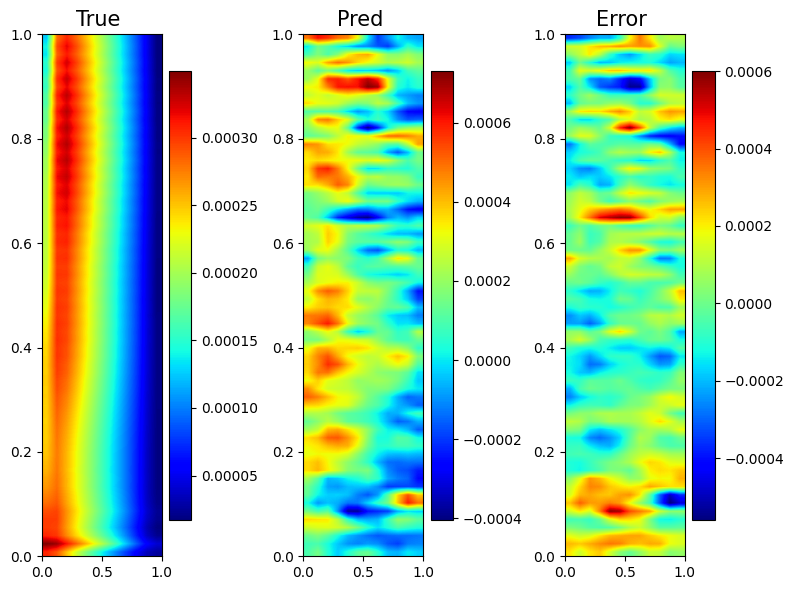

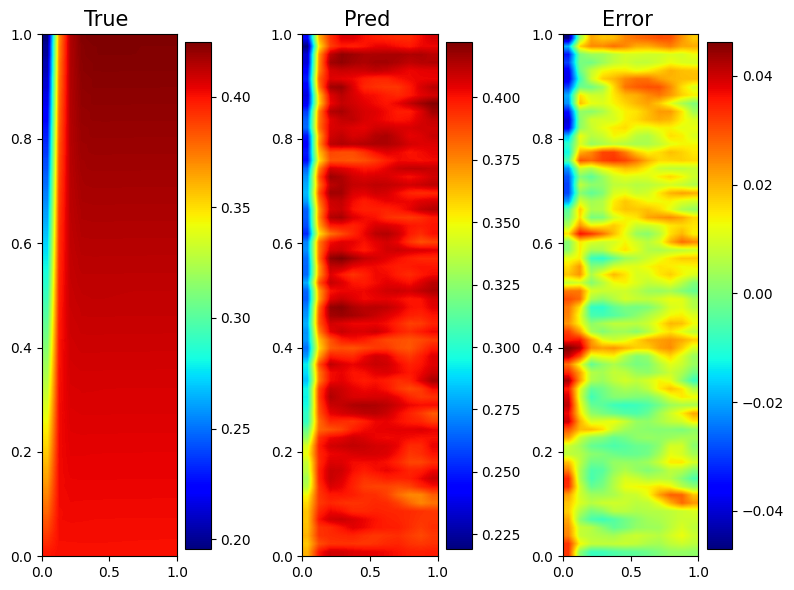

In [ ]:
pred, data = fluid_p, fluid
phy_lis = ["T", "P", "vx", "vy"]
for i in range(4):

    channel = i

    plot_compare_2d(
        data[-1, channel, -1],
        pred[-1, channel, -1],
        savep="../../results/nuclear_thermal_coupling/fluid" + phy_lis[i] + "_surrogate" + model_type + ".png",
    )